In [1]:
require(readr)
require(ggplot2)
require(reshape2)

Loading required package: readr
Loading required package: ggplot2
Loading required package: reshape2


# Scaling Methods: Chapter 3

I ran tests on the following machine-learning algorithms:

- Random Forest
- Support Vector Machines with Radial Basis Function kernel
- Support Vector Machines with Linear kernel
- Gradient Boosting
- Logistic Regression

>All tests were run in Python using the scikit-learn and pandas packages. The tests were run on the Fulton Supercomputer using SLURM jobs. Source code can be found at my Github repo [here](https://github.com/zence/SCCR/tree/super-computer/python/AUC_tests/normalization_tests)

I ran 5 stratified k-fold cross validation on all genes to predict HER2 positivity. Each test was run 10 times using a different random seed from a list of set numbers. AUC was recorded and averaged for each test and I got the following results for the different algorithms and normalization methods:

In [2]:
avg.auc.results <- as.data.frame(read_tsv("../results/avg_auc_table.tsv"))
avg.auc.results

Parsed with column specification:
cols(
  model = col_character(),
  norm_quan = col_double(),
  norm_quan_robust = col_double(),
  quan_tran = col_double(),
  robust = col_double(),
  standard = col_double(),
  vsd = col_double(),
  vsd_robust = col_double()
)


model,norm_quan,norm_quan_robust,quan_tran,robust,standard,vsd,vsd_robust
GB,0.7586220,0.7586220,0.7588659,0.7596268,0.7565798,0.7649855,0.7649855
rbf_SVM,0.5000000,0.5000000,0.5000000,0.5000000,0.6063741,0.6936962,0.6804401
linear_SVM,0.7224602,0.5536011,0.7437777,0.6334645,0.7374727,0.7516410,0.7478501
LR,0.7280607,0.5400416,0.7383536,0.6334418,0.7547895,0.7499853,0.7594389
RF,0.6764053,0.6764053,0.6719397,0.6719127,0.6719127,0.6722935,0.6722935


I'm going to make this a little more readable

In [3]:
avg.auc.results$model <- c('Gradient Boosting', 'SVM (rbf)', 'SVM (linear)', 'Logistic Regression', 'Random Forest')
names(avg.auc.results) <- c('model', 'Normalized Quantile', 'Normalized Quantile + Robust', 'Quantile Transform', 'Robust', 'Standard', 'VSD', 'VSD + Robust')

In [4]:
avg.auc.results

model,Normalized Quantile,Normalized Quantile + Robust,Quantile Transform,Robust,Standard,VSD,VSD + Robust
Gradient Boosting,0.7586220,0.7586220,0.7588659,0.7596268,0.7565798,0.7649855,0.7649855
SVM (rbf),0.5000000,0.5000000,0.5000000,0.5000000,0.6063741,0.6936962,0.6804401
SVM (linear),0.7224602,0.5536011,0.7437777,0.6334645,0.7374727,0.7516410,0.7478501
Logistic Regression,0.7280607,0.5400416,0.7383536,0.6334418,0.7547895,0.7499853,0.7594389
Random Forest,0.6764053,0.6764053,0.6719397,0.6719127,0.6719127,0.6722935,0.6722935


Now I'm going to melt the dataframe so I can more easily graph the data

In [5]:
avg.auc.results <- melt(avg.auc.results, id=c("model"))
avg.auc.results

model,variable,value
Gradient Boosting,Normalized Quantile,0.7586220
SVM (rbf),Normalized Quantile,0.5000000
SVM (linear),Normalized Quantile,0.7224602
Logistic Regression,Normalized Quantile,0.7280607
Random Forest,Normalized Quantile,0.6764053
Gradient Boosting,Normalized Quantile + Robust,0.7586220
SVM (rbf),Normalized Quantile + Robust,0.5000000
SVM (linear),Normalized Quantile + Robust,0.5536011
Logistic Regression,Normalized Quantile + Robust,0.5400416
Random Forest,Normalized Quantile + Robust,0.6764053


There, now I will compare the average AUCs across different algorithms

In [6]:
norm.methods <- c("Standard", "Robust", "Quantile Transform", "Normalized Quantile", "Normalized Quantile + Robust", "VSD", "VSD + Robust")
models <- unique(avg.auc.results$model)

In [7]:
ggmeth <- c()
for (method in norm.methods){
    gbar <- ggplot(avg.auc.results[which(avg.auc.results$variable == method),], aes(x = model, y = value, fill = model))
    ggbar <- gbar + geom_bar(stat = "identity") + ylim(0, 1) + coord_cartesian(y = c(0.5, 1)) + 
                labs(title = method) + 
                geom_text(aes(label = round(value, digits = 3), angle = 45, hjust = 0, vjust = 0)) +
                theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))

    ggmeth[[method]] <- ggbar
}

We'll look at all of the methods individually

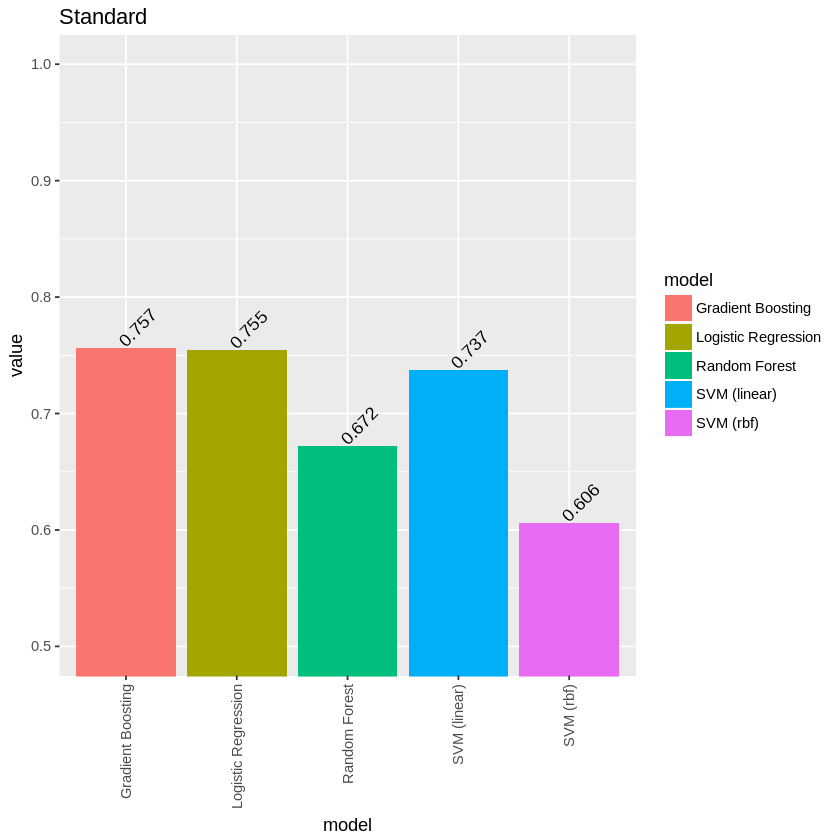

In [9]:
ggmeth[["Standard"]]

We see that Random Forest and SVM with the 'rbf' kernel underperform, but especially SVM. We will see a similar trend with the other algorithms.

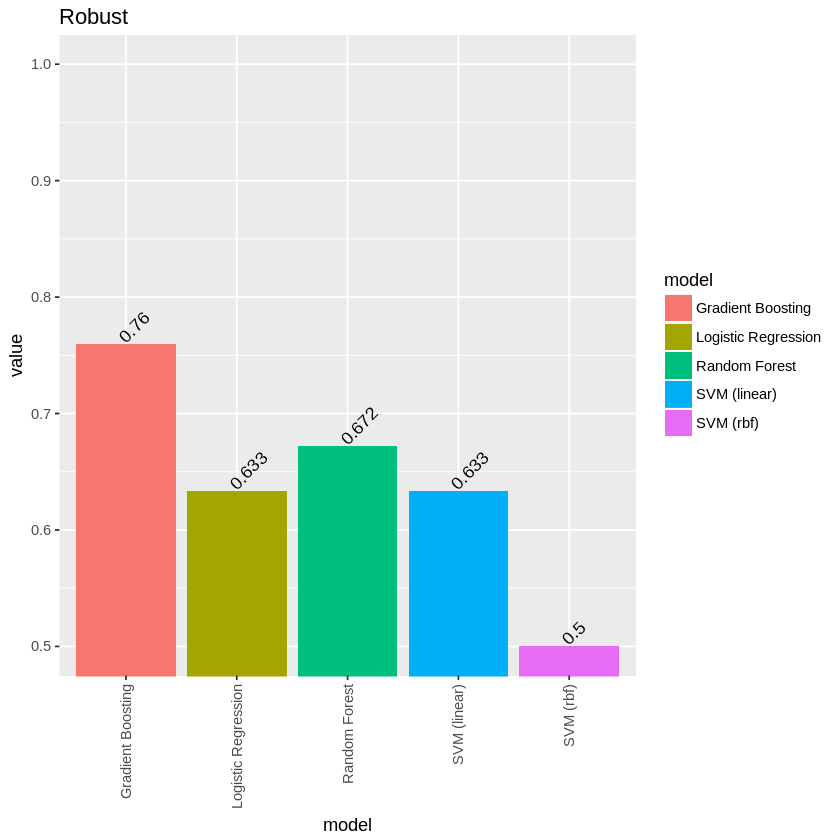

In [10]:
ggmeth[["Robust"]]

Gradient Boosting holds its own while Random Forest seems to suffer less when Robust Scaler is used. SVM with rbf severely underperforms with the lowest possible AUC.

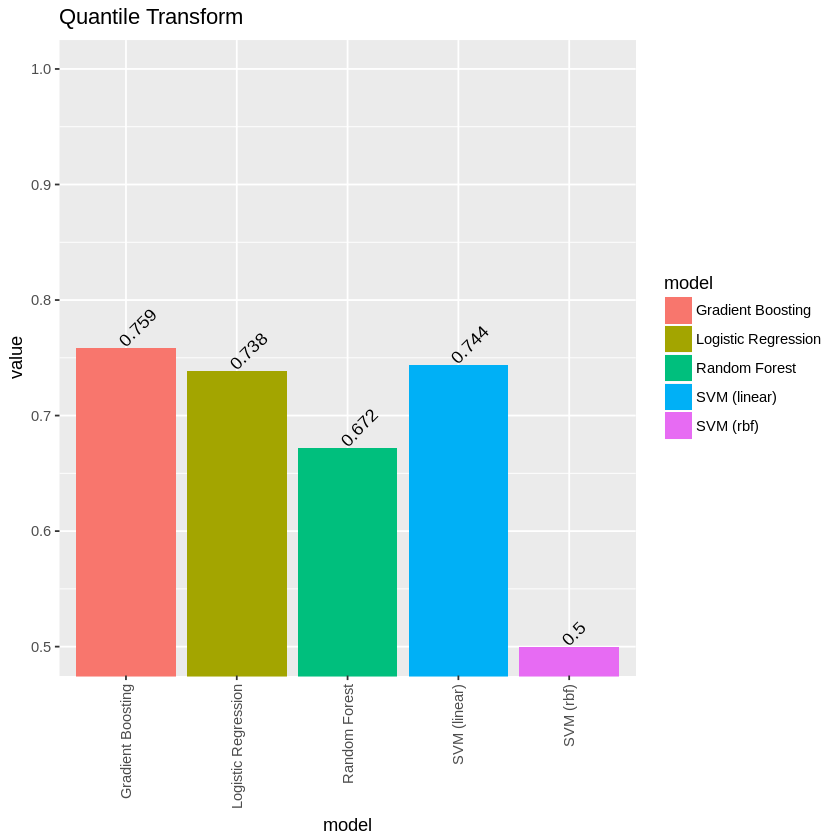

In [11]:
ggmeth[["Quantile Transform"]]

Again, we see that Gradient Boosting performs best and SVM (rbf) suffers greatly. It is also notable that this reflects a more extreme outcome as that from the standard scaler.

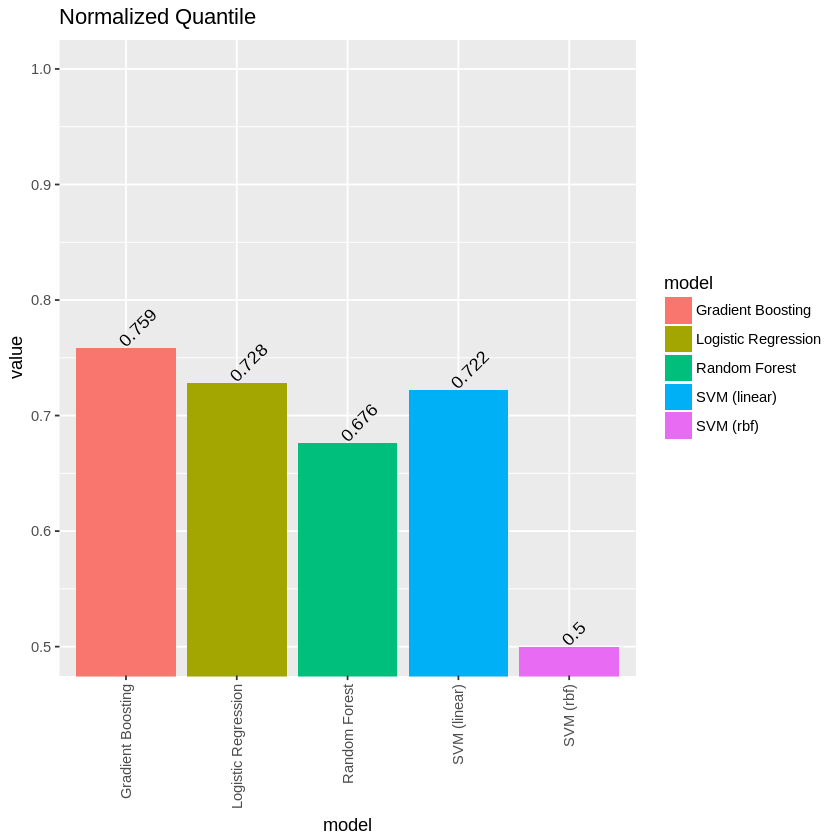

In [12]:
ggmeth[["Normalized Quantile"]]

This is nearly identical to quantile transform, so I will not discuss it.

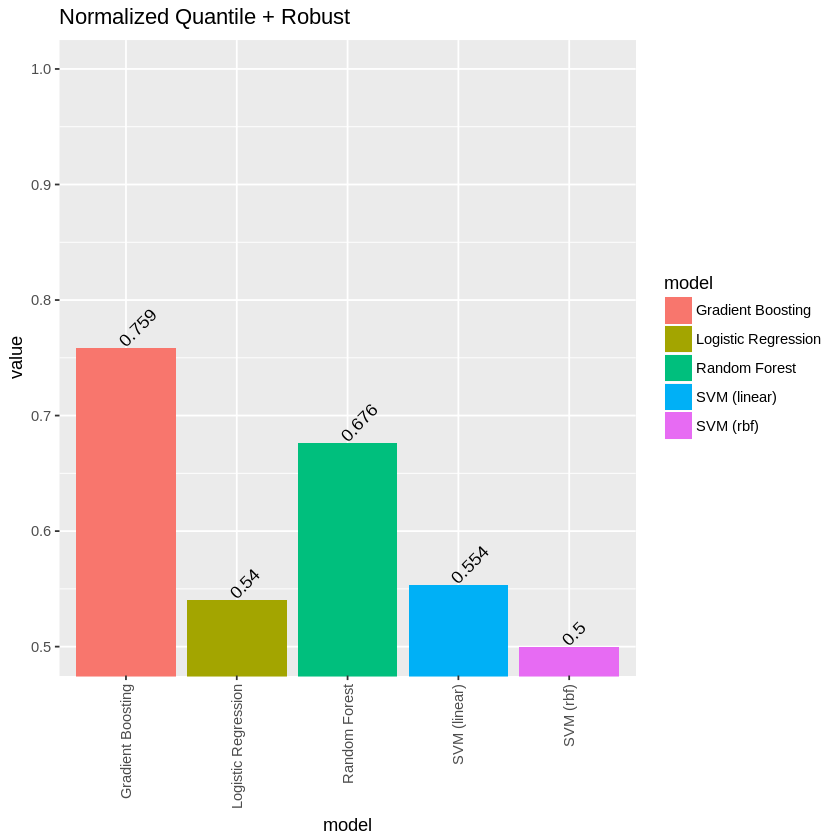

In [13]:
ggmeth[["Normalized Quantile + Robust"]]

This is interesting: Random Forest, along with Gradient Boosting, seems to be unaffected by the robust scaler. Gradient Boosting can do anything. Gradient Boosting ain't got time for your games.

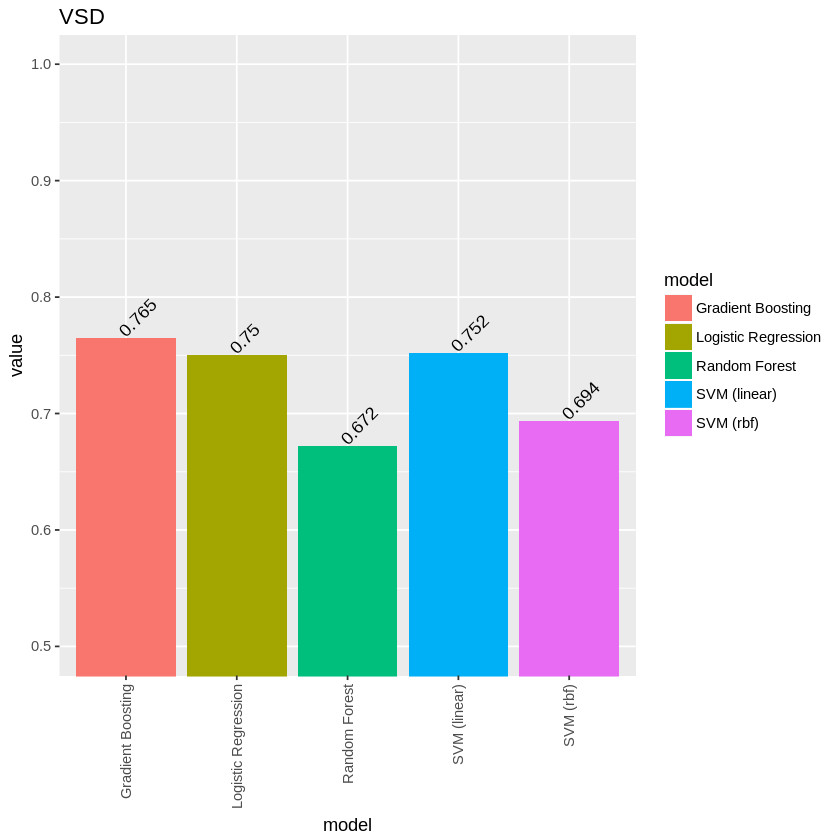

In [15]:
ggmeth[["VSD"]]

BioConductor's VST method seems to improve the AUC of all of the algorithms, including SVM (rbf), although its results are still not up to par with some of the other algorithms.

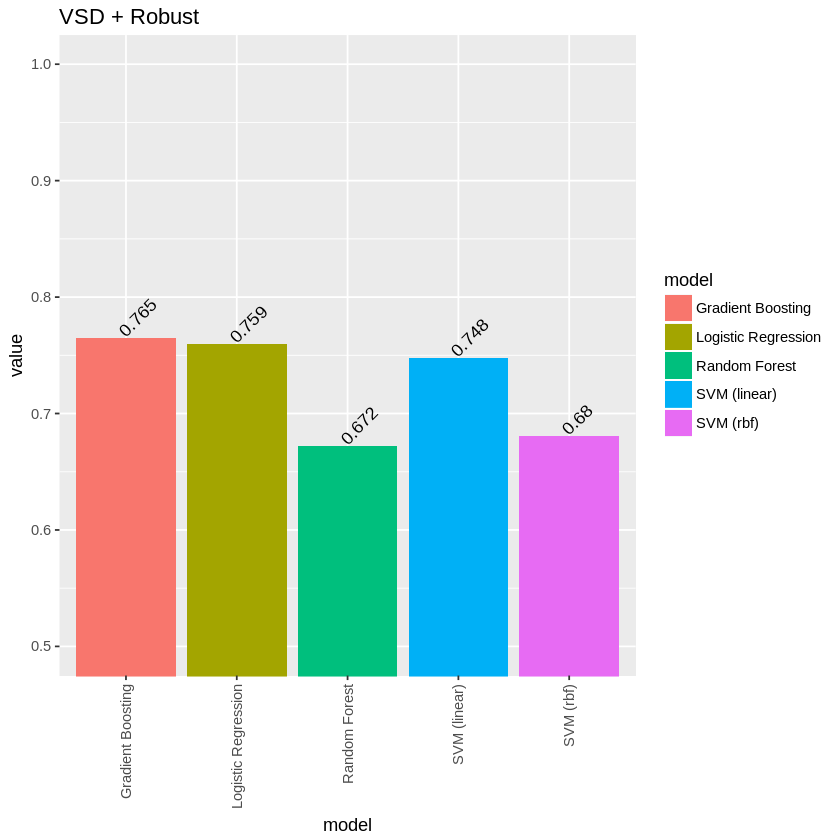

In [17]:
ggmeth[["VSD + Robust"]]

We see that Random Forest, again, is unaffected by the robust scaler, while it negatively affected SVMs. It, surprisingly enough, improved performance by Logistic Regression.

These results are a little difficult to draw conclusions from, so I will now attempt to find the best normalization method for each algorithm

Now, let's compare the methods across models

In [8]:
ggalg <- c()
for (alg in models){
    gbar <- ggplot(avg.auc.results[which(avg.auc.results$model == alg),], aes(x = variable, y = value, fill = variable))
    ggbar <- gbar + geom_bar(stat = "identity") + ylim(0, 1) + coord_cartesian(y = c(0.5, 1)) + 
                labs(title = alg, fill = "Normalization Method", x = "Normalization Method") +
                geom_text(aes(label = round(value, digits = 3), angle = 45, hjust = 0, vjust = 0)) +
                theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))

    ggalg[[alg]] <- ggbar
}

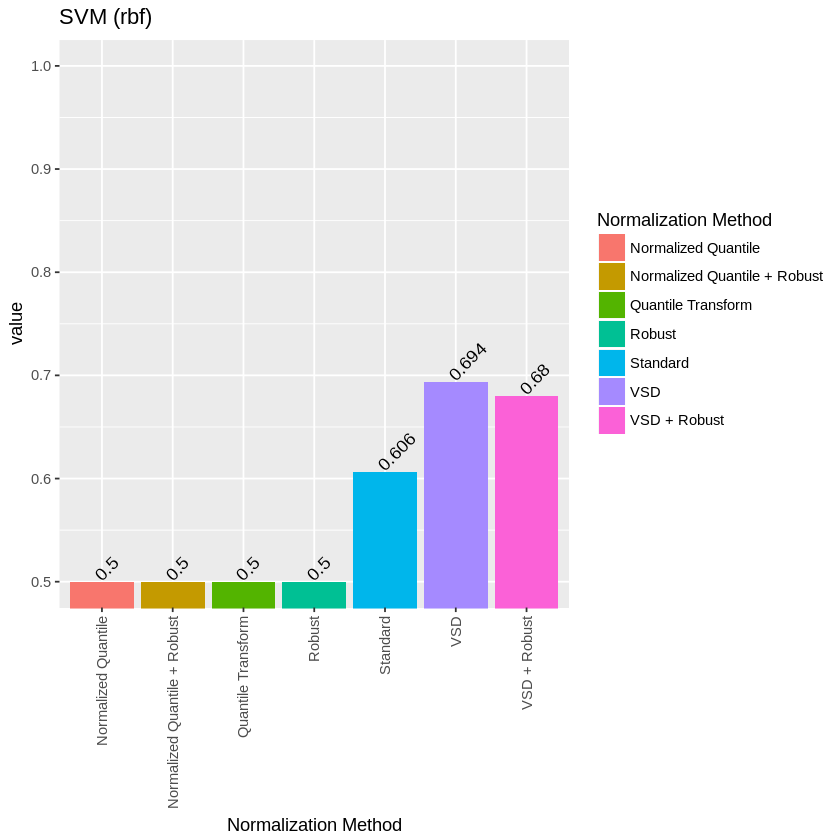

In [18]:
ggalg[["SVM (rbf)"]]

As we saw earlier, SVM with an rbf kernel does not perform well on this data. I may be able to improve performance by playing around with different parameters, but I might hold off on that for now.

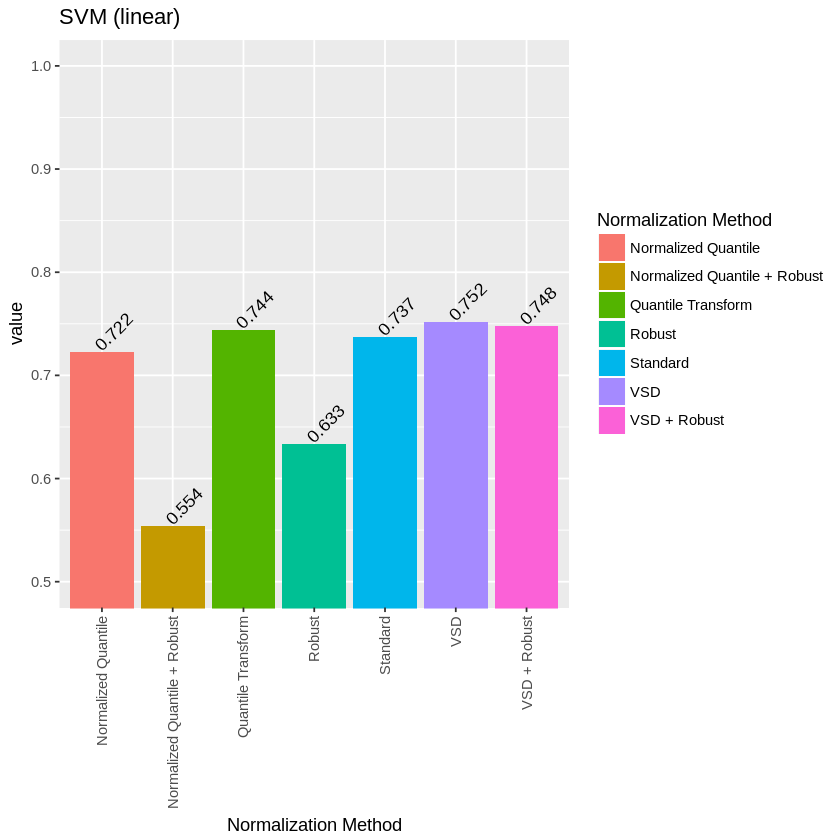

In [19]:
ggalg[["SVM (linear)"]]

In this particular dataset, SVM with a linear kernel outperforms its rbf counterpart in all tests. It should be noted that SVM (rbf) and SVM (linear) were run with all of the same parameters _except_ for having different kernels.

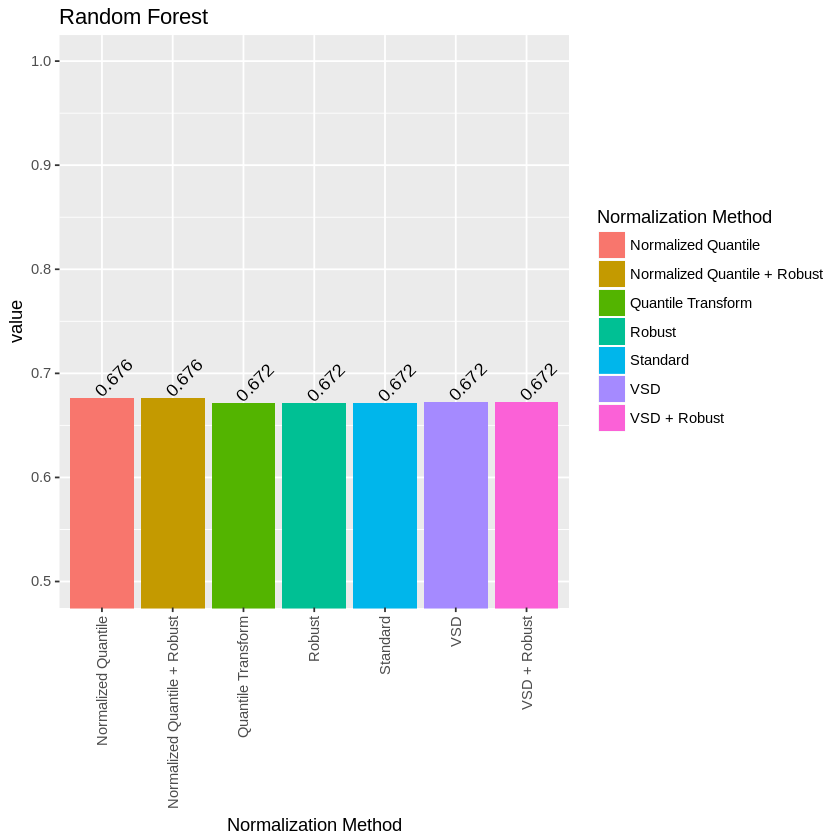

In [20]:
ggalg[["Random Forest"]]

Random Forest remains rather unaffected by normalization methods, although it still never really performs that well. It should be noted that I ran the random forest algorithm with 10 estimators, and adding more estimators may improve accuracy, but I'll worry about that later.

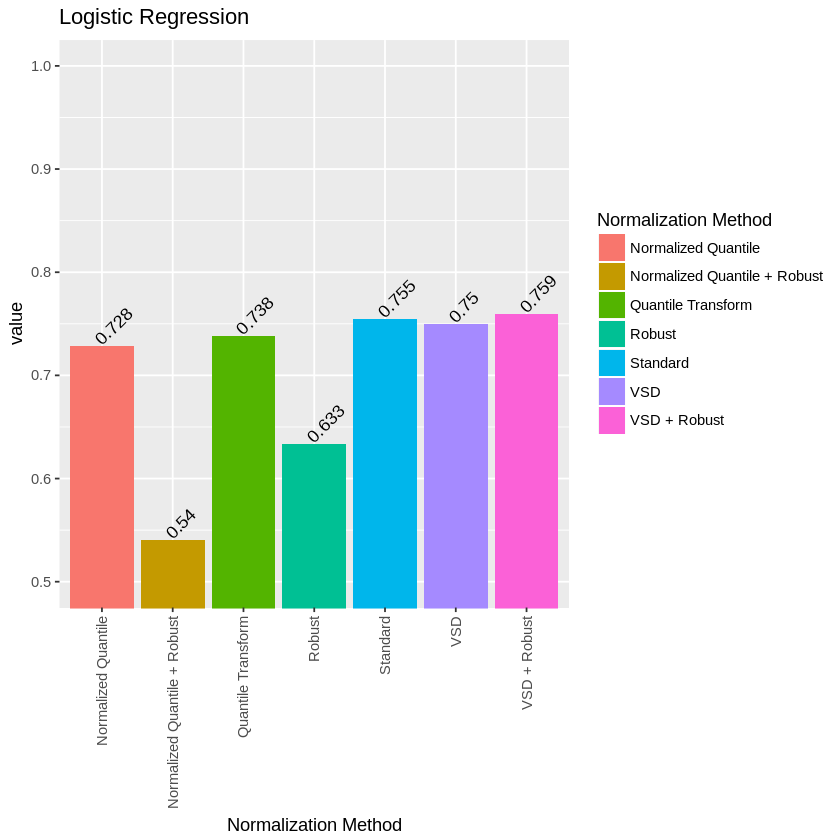

In [21]:
ggalg[["Logistic Regression"]]

Logistic Regression is, surprisingly enough, a fairly accurate algorithm. It performs (very slightly) better with VSD + Robust.

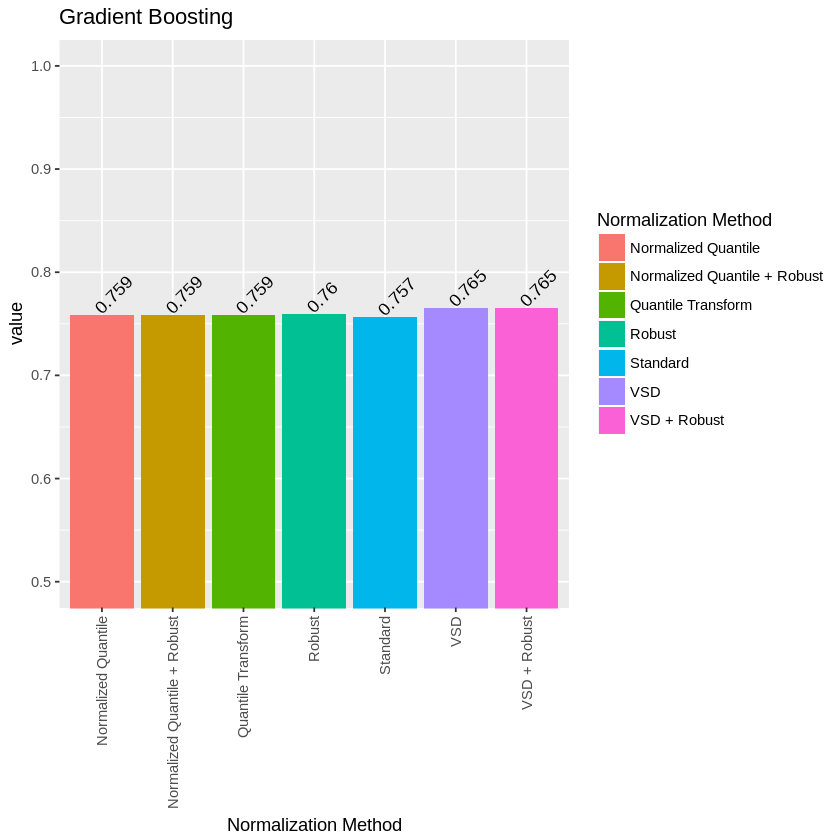

In [22]:
ggalg[["Gradient Boosting"]]

Ladies and Gentlemen, I give you Gradient Boosting. It's worst performance ties with the best performance from all of the other algorithms tested. Although only slight, it does show improvement when used on VST transformed data, and the robust scaler has no effect on performance. It should probably notice that, while I may not have timed the algorithms, they were running in parallel and Gradient Boosting took the longest by far.

Next, I will analyze the individual algorithms using all of the data points. In order to do this, I had to rerun my tests, preventing my pipeline from averaging out any values, giving me every AUC. We will then see which AUCs are precise as well as accurate.

In [23]:
raw_aucs <- as.data.frame(read_tsv("../results/AUC/raw_aucs.tsv"))

Parsed with column specification:
cols(
  model = col_character(),
  method = col_character(),
  auc = col_double()
)


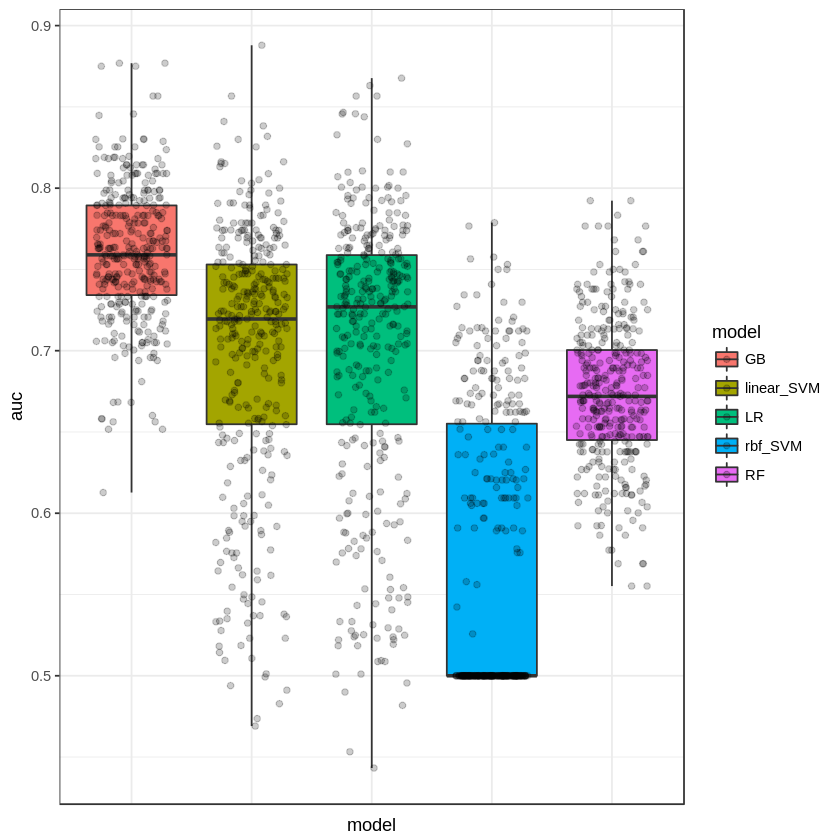

In [37]:
gbox <- ggplot(raw_aucs, aes(x = model, y = auc, fill = model))
ggbox <- gbox + geom_boxplot(coef = 25) + geom_jitter(width = .3, alpha = .2) +
            theme_bw() +
            theme(axis.ticks.x = element_blank(), 
                  axis.text.x = element_blank())

ggbox

>I had something here, but then realized that what I had said was incorrect